# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

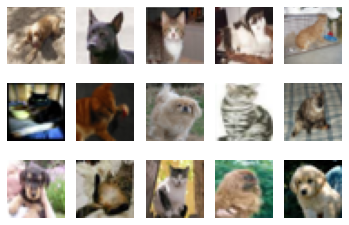

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("The number of training examples is:", len(train_loader))
print("The number of validation examples is:", len(val_loader))
print("The number of test examples is:", len(test_loader))

The number of training examples is: 8000
The number of validation examples is: 2000
The number of test examples is: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Answer:**

Validation set is used to tune our hyperparameters on them. Training set is used to update the model's parameters including weights and biases. We run our model on the test set once we are done with updating our parameters and hyperparameters to find out how well our model performs on an unseen data or how well it generalizes. We cannot use traning set to judge the performance of our model because during the training we are still updating our parameters. Even if we're done with updating our parameters, to check the performance of the model, we cannot judge the performance using train set because we want to test the model on an unseen data (test set). If we test the performance of the model on our train set (seen data), we won't be able to find out how our model performs because the model has already seen that data and was trained on that. So bascially, our model would be overfitted to the training set and will not perform well later on an unseen data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
total_params_small_net = 0
for param in small_net.parameters():
    total_size = 1
    print(param.shape)
    for i in range(len(param.shape)):
      total_size *= param.shape[i]
    total_params_small_net += total_size
print("The total number of parameters in small_net is:", total_params_small_net)

print("\n")
total_params_large_net = 0
for param in large_net.parameters():
    total_size = 1
    print(param.shape)
    for i in range(len(param.shape)):
      total_size *= param.shape[i]
    total_params_large_net += total_size
print("The total number of parameters in small_net is:", total_params_large_net)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
The total number of parameters in small_net is: 386


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in small_net is: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

**Answer:**

The default value of the batch_size is 64, learning_rate is 0.01, and num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446875, Train loss: 0.6811520709991455 |Validation err: 0.3795, Validation loss: 0.6565094832330942
Epoch 2: Train err: 0.36825, Train loss: 0.6466353402137757 |Validation err: 0.3715, Validation loss: 0.659591207280755
Epoch 3: Train err: 0.344375, Train loss: 0.6262089643478393 |Validation err: 0.332, Validation loss: 0.6158446669578552
Epoch 4: Train err: 0.326625, Train loss: 0.6091874675750732 |Validation err: 0.34, Validation loss: 0.619335750117898
Epoch 5: Train err: 0.32125, Train loss: 0.6006861662864685 |Validation err: 0.3295, Validation loss: 0.6117261555045843
Finished Training
Total time elapsed: 21.79 seconds


**Answer:**

The files written to disk are:

- model_small_bs64_lr0.01_epoch0
  - contains checkpoint at epoch0
- model_small_bs64_lr0.01_epoch1
  - contains checkpoint at epoch1
- model_small_bs64_lr0.01_epoch2
  - contains checkpoint at epoch1
- model_small_bs64_lr0.01_epoch3
  - contains checkpoint at epoch3
- model_small_bs64_lr0.01_epoch4
  - contains checkpoint at epoch4
- model_small_bs64_lr0.01_epoch4_train_err.csv
  - contains training error of each epoch
- model_small_bs64_lr0.01_epoch4_train_loss.csv
  - contains training loss of each epoch
- model_small_bs64_lr0.01_epoch4_val_err.csv
  - contains validation error of each epoch
- model_small_bs64_lr0.01_epoch4_vali_loss.csv
  - contains validation loss of each epoch

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.331125, Train loss: 0.6078785486221313 |Validation err: 0.332, Validation loss: 0.621172958984971
Epoch 2: Train err: 0.32275, Train loss: 0.6004721961021423 |Validation err: 0.338, Validation loss: 0.6301042437553406
Epoch 3: Train err: 0.31475, Train loss: 0.5946184163093566 |Validation err: 0.3345, Validation loss: 0.6059183161705732
Epoch 4: Train err: 0.3135, Train loss: 0.586517691373825 |Validation err: 0.3425, Validation loss: 0.6094269417226315
Epoch 5: Train err: 0.307875, Train loss: 0.5807497251033783 |Validation err: 0.323, Validation loss: 0.6044520493596792
Epoch 6: Train err: 0.302125, Train loss: 0.5733250217437744 |Validation err: 0.325, Validation loss: 0.6014664182439446
Epoch 7: Train err: 0.2955, Train loss: 0.570032117843628 |Validation err: 0.323, Validation loss: 0.5946711264550686
Epoch 8: Train err: 0.3, Train loss: 0.5660981757640838 |Validation err: 0.3235, Val

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454625, Train loss: 0.6889029908180236 |Validation err: 0.42, Validation loss: 0.6767712496221066
Epoch 2: Train err: 0.41, Train loss: 0.6735128283500671 |Validation err: 0.4285, Validation loss: 0.6780253164470196
Epoch 3: Train err: 0.386625, Train loss: 0.6562490754127502 |Validation err: 0.3535, Validation loss: 0.6396026015281677
Epoch 4: Train err: 0.35425, Train loss: 0.6355569548606873 |Validation err: 0.347, Validation loss: 0.6238625645637512
Epoch 5: Train err: 0.3355, Train loss: 0.618867829799652 |Validation err: 0.328, Validation loss: 0.6147242113947868
Epoch 6: Train err: 0.327625, Train loss: 0.605054744720459 |Validation err: 0.3415, Validation loss: 0.6191190890967846
Epoch 7: Train err: 0.319875, Train loss: 0.5920553193092346 |Validation err: 0.337, Validation loss: 0.614622613415122
Epoch 8: Train err: 0.311375, Train loss: 0.5815684967041016 |Validation err: 0.3125,

**Answer:**

As one can observe, the total elapsed time for large net is 114.26 seconds while it is 105.33 seconds for small net. The result was expected because training a large net requires more parameters and so it is more complex. Training a small net with smaller number of hidden units and layers compared to larget net is taking less time as it is not as complex as a large net and had fewer parameters to update.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

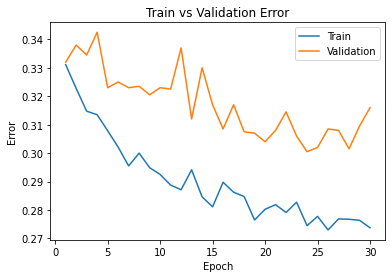

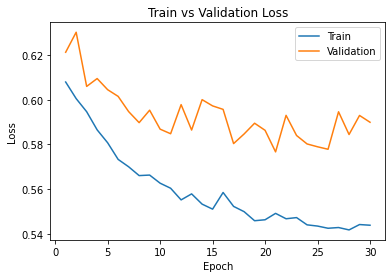

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

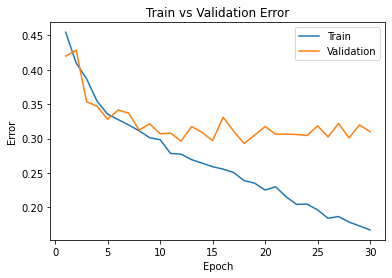

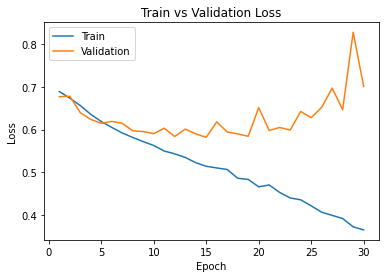

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Answer:**

Both training and validation loss of small net and large net start with a high error and loss and then eventually decreases until some point. The reason behind this is that model is updating its parameters after each epoch and so improves the performance of the model and following that reduce the loss and error. The plots for small net is noisier than large net as the model is simpler in small net and so the plots are not smooth. For both small and larget net, we should pick a smaller epoch since at some point in both, plots are either plateau or rise up. According to plots of small net, I would say 8 epoch is enough to run the model since after that, the model is not improving anymore and the different between graphs of training and validation is increasing so the model start to overfit. For large net, the appropriate number of epoch is around 10 since the model will be overfitting after that (training error/loss is decreasing but validation error/loss in increasing).

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

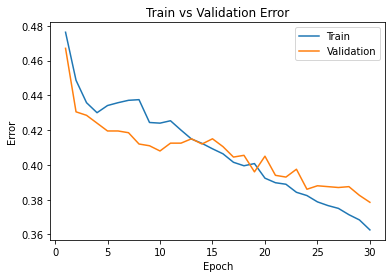

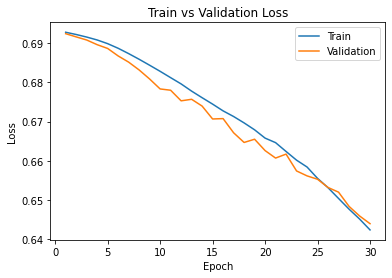

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

**Answer:**

The total elapsed time did not significantly change. But one can observe that in higher epochs both train and validation error/loss is decreasing with 0.001 learning rate and so the model is not overfitting. The reason behind this is that since learning rate is smaller, the steps are smaller and model is learning better. It basically allows model to learn a more optimal set of parameters. In some cases, the convergence with smaller learning rate is slower but not here as we saw that the total elapsed time did not significantly change. Also, both train and validation loss/error are reducing and they did not stop which is showing the underfitting.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

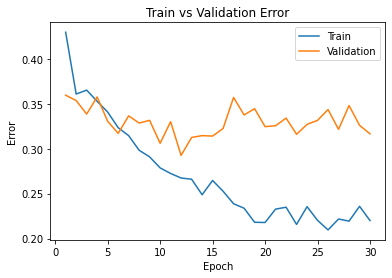

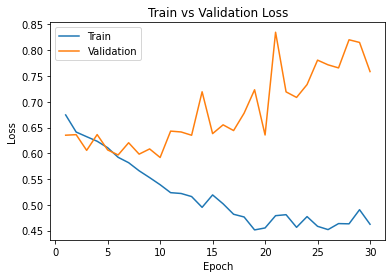

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

**Answer:**

The total elapsed time did not significantly change again. But one can observe that our model is now overfitting sooner compared to when our learning rate was 0.01 (default case) as we can see that after epoch 5, the validation loss curve is increasing while train loss curve is reducing. So with higher learning rate, our model is not performing well and our gradients can explode. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

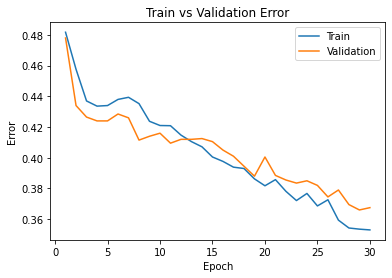

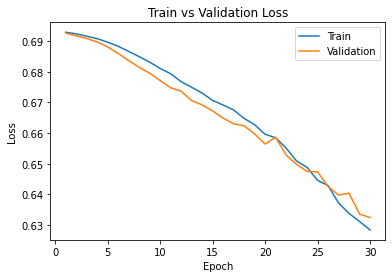

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer:**

The total elapsed time reduced this time around 17 seconds. But this does not mean that our performance improved. Our train loss/error increased compared to the model in part (b) which has lower batch size and the same learning rate. Both train and validation loss/error are reducing and they did not stop which is showing the underfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

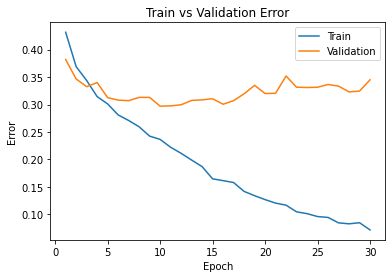

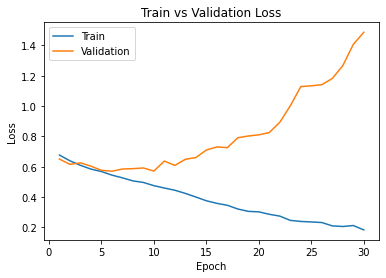

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

**Answer:**

The total elapsed time increased significantly this time around 50 seconds. The first obvious behaviour that we can see on both graphs is overfitting as in both graphs, we can see that after epoch 5, the validation loss/error is increasing with decreasing train loss/error and increasing number of epochs. This model is obviously not performing well and it does not generalizes well.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer**:

I would go with "large_net, batch_size=512, learning_rate=0.001, num_epochs=30".

We saw in part 2 that large net is less noisier. Batch size of 512 is a good batch size as we saw in part 3 (c) that increasing batch size reduce overfitting. Smaller learning rate also reduce overfitting as we saw in part 3 (a).

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.503375, Train loss: 0.6931838169693947 |Validation err: 0.5065, Validation loss: 0.6938159167766571
Epoch 2: Train err: 0.503625, Train loss: 0.6930505260825157 |Validation err: 0.5085, Validation loss: 0.6936859637498856
Epoch 3: Train err: 0.50375, Train loss: 0.6929039172828197 |Validation err: 0.51, Validation loss: 0.6936599463224411
Epoch 4: Train err: 0.503375, Train loss: 0.6928931772708893 |Validation err: 0.5055, Validation loss: 0.69358791410923
Epoch 5: Train err: 0.502875, Train loss: 0.6926453597843647 |Validation err: 0.5065, Validation loss: 0.6934588700532913
Epoch 6: Train err: 0.501125, Train loss: 0.6925876028835773 |Validation err: 0.5045, Validation loss: 0.693279892206192
Epoch 7: Train err: 0.498375, Train loss: 0.6924448646605015 |Validation err: 0.4995, Validation loss: 0.693187952041626
Epoch 8: Train err: 0.499, Train loss: 0.6922980733215809 |Validation err: 0.

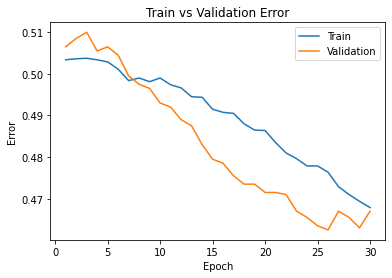

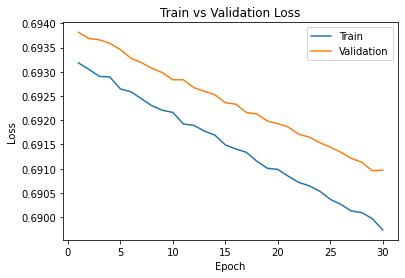

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

It seems that with above chosen hyperparameters, we get a little bit of gap between training and validation set. Also we can still see the sign of underfitting at the beginning as we have a high train and validation error/loss. I would increase my learning rate to 0.005 as we saw in part 3 (c) that with learning rate of 0.01, we have less gap between validation and train loss/error.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.486125, Train loss: 0.6930099949240685 |Validation err: 0.4925, Validation loss: 0.6929330974817276
Epoch 2: Train err: 0.4745, Train loss: 0.6927304826676846 |Validation err: 0.46, Validation loss: 0.6924416720867157
Epoch 3: Train err: 0.453875, Train loss: 0.6923640854656696 |Validation err: 0.439, Validation loss: 0.6920483112335205
Epoch 4: Train err: 0.447625, Train loss: 0.6920197159051895 |Validation err: 0.4325, Validation loss: 0.6916171312332153
Epoch 5: Train err: 0.43625, Train loss: 0.6915771439671516 |Validation err: 0.427, Validation loss: 0.6910792589187622
Epoch 6: Train err: 0.436, Train loss: 0.6911384649574757 |Validation err: 0.4275, Validation loss: 0.6905113160610199
Epoch 7: Train err: 0.439875, Train loss: 0.6906684786081314 |Validation err: 0.4265, Validation loss: 0.6898608803749084
Epoch 8: Train err: 0.44375, Train loss: 0.6901445500552654 |Validation err: 0.4

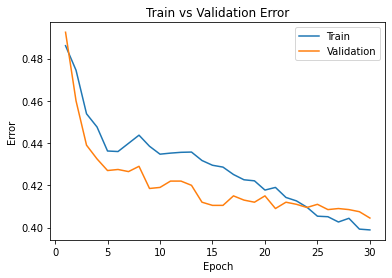

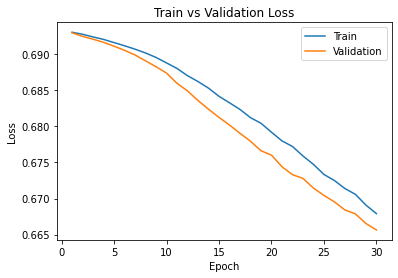

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.005, num_epochs=30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Answer**:

I went with "large_net, batch_size=512, learning_rate=0.005, num_epochs=29".

We saw in part 2 that large net is less noisier. Batch size of 512 is a good batch size as we saw in part 3 (c) that increasing batch size reduce overfitting. Smaller learning rate also reduce overfitting as we saw in part 3 (a) but choosing a very small learning rate would increase chance of overfitting so I picked 0.005 which is between 0.01 from part 3 (c) and 0.001 which is from part 4 (b).

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)
print(("Test err: {}, Test loss: {}").format(err, loss))

Test err: 0.3915, Test loss: 0.661542683839798


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
val_criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(net, val_loader, criterion)
print(("Validation err: {}, Validation loss: {}").format(val_err, val_loss))

Validation err: 0.4045, Validation loss: 0.6657802164554596


**Answer**:

Validation set is used to tune model's hyperparameters to find a model that generalize well and does not overfit to the train data. 

Test set is used to evaluate performance of the model only once to findout whether our final model can generalize to new unseen data or not.

Usually the validation error should be lower than test error because model has not seen the data in test set. But here validation error is higher than test error and this can be due to the fact that test data is very similar to train data and so the measurement is being done on a data that model performs well on it. We should test model with other test data as well and if it performs well again, it means that our model is a very good one and it performs and generalize very well.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer**:

Because we should only run the model once with the test data as the test data is used to evaluate the final model's performance and if we used it earlier during validation phase or training phase, we would not know that how model would perform on an unseen data. We want a model to does not overfit to train data or only be able to perform well some data. We want it to generalize well and being able to perform well on new data that has not seen before. Otherwise, there is no point of designing a machine learning algorithm to do a task for us. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

# First Model:

hyperparameters: 

batch_size=512, learning_rate=0.005, num_epochs=30

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.457125, Train loss: 0.685588177293539 |Validation err: 0.428, Validation loss: 0.6721940785646439
Epoch 2: Train err: 0.407875, Train loss: 0.6675471849739552 |Validation err: 0.4055, Validation loss: 0.664011999964714
Epoch 3: Train err: 0.399625, Train loss: 0.6598906591534615 |Validation err: 0.3995, Validation loss: 0.6598189324140549
Epoch 4: Train err: 0.387875, Train loss: 0.6538973599672318 |Validation err: 0.4025, Validation loss: 0.656045526266098
Epoch 5: Train err: 0.38225, Train loss: 0.6491840779781342 |Validation err: 0.396, Validation loss: 0.6539030075073242
Epoch 6: Train err: 0.379125, Train loss: 0.6460498794913292 |Validation err: 0.394, Validation loss: 0.6521193534135818
Epoch 7: Train err: 0.37125, Train loss: 0.6420500949025154 |Validation err: 0.3895, Validation loss: 0.6508487313985825
Epoch 8: Train err: 0.36725, Train loss: 0.6385269984602928 |Validation err: 0

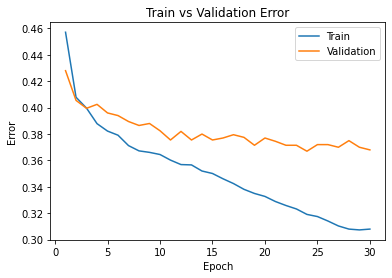

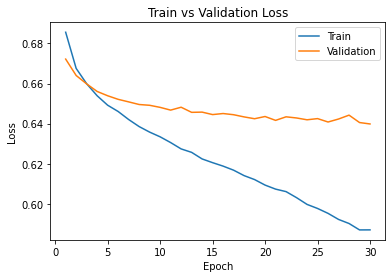

Files already downloaded and verified
Files already downloaded and verified
Test err: 0.357, Test loss: 0.6357005536556244
Validation err: 0.368, Validation loss: 0.6399194300174713


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(3* 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3* 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()
train_net(pigeon, batch_size=512, learning_rate=0.005, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=512, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, criterion)
print(("Test err: {}, Test loss: {}").format(err, loss))

val_criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(pigeon, val_loader, criterion)
print(("Validation err: {}, Validation loss: {}").format(val_err, val_loss))

# Second Model:

hyperparameters: 

batch_size=512, learning_rate=0.001, num_epochs=30

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.450875, Train loss: 0.6890586093068123 |Validation err: 0.4445, Validation loss: 0.6858400255441666
Epoch 2: Train err: 0.423125, Train loss: 0.6838171146810055 |Validation err: 0.425, Validation loss: 0.6805253475904465
Epoch 3: Train err: 0.41175, Train loss: 0.6787896603345871 |Validation err: 0.4175, Validation loss: 0.6766963601112366
Epoch 4: Train err: 0.406625, Train loss: 0.6747261509299278 |Validation err: 0.412, Validation loss: 0.6734503954648972
Epoch 5: Train err: 0.405, Train loss: 0.6711519472301006 |Validation err: 0.413, Validation loss: 0.6708834022283554
Epoch 6: Train err: 0.403125, Train loss: 0.6687435992062092 |Validation err: 0.4125, Validation loss: 0.6687508523464203
Epoch 7: Train err: 0.398625, Train loss: 0.6663715988397598 |Validation err: 0.4095, Validation loss: 0.6672805994749069
Epoch 8: Train err: 0.39675, Train loss: 0.6643129326403141 |Validation err: 

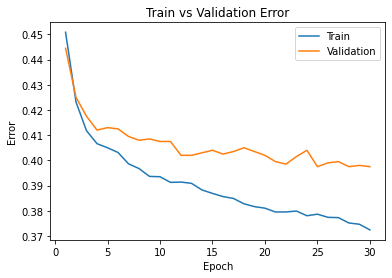

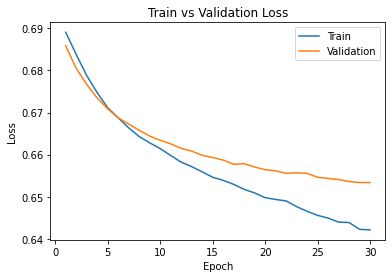

Files already downloaded and verified
Files already downloaded and verified
Test err: 0.3745, Test loss: 0.6450681537389755
Validation err: 0.3975, Validation loss: 0.6534742414951324


In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=512, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, criterion)
print(("Test err: {}, Test loss: {}").format(err, loss))

val_criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(pigeon, val_loader, criterion)
print(("Validation err: {}, Validation loss: {}").format(val_err, val_loss))

# Third Model:

hyperparameters: 

batch_size=128, learning_rate=0.001, num_epochs=30

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439125, Train loss: 0.6825061989209008 |Validation err: 0.4185, Validation loss: 0.6703247837722301
Epoch 2: Train err: 0.398375, Train loss: 0.6659635806840564 |Validation err: 0.4075, Validation loss: 0.6617407985031605
Epoch 3: Train err: 0.392375, Train loss: 0.6590904366402399 |Validation err: 0.398, Validation loss: 0.6594215221703053
Epoch 4: Train err: 0.388625, Train loss: 0.6541059064486671 |Validation err: 0.397, Validation loss: 0.6560722999274731
Epoch 5: Train err: 0.38075, Train loss: 0.6500562183440678 |Validation err: 0.392, Validation loss: 0.654391311109066
Epoch 6: Train err: 0.380625, Train loss: 0.6469952360032096 |Validation err: 0.392, Validation loss: 0.6537671089172363
Epoch 7: Train err: 0.377375, Train loss: 0.6440320686688499 |Validation err: 0.389, Validation loss: 0.6518063247203827
Epoch 8: Train err: 0.369125, Train loss: 0.6411269165220714 |Validation err:

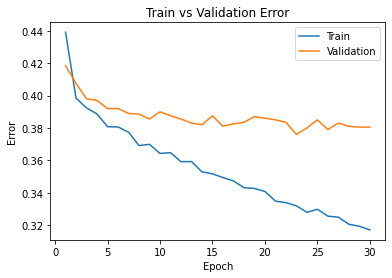

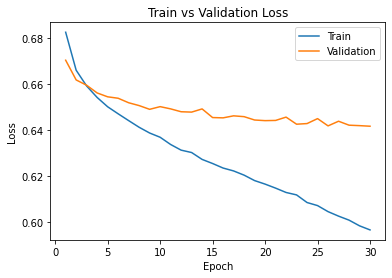

Files already downloaded and verified
Files already downloaded and verified
Test err: 0.352, Test loss: 0.6366753131151199
Validation err: 0.3805, Validation loss: 0.6424915045499802


In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=128, learning_rate=0.001, num_epochs=30)
model_path = get_model_name("pigeon", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, criterion)
print(("Test err: {}, Test loss: {}").format(err, loss))

val_criterion = nn.BCEWithLogitsLoss()
val_err, val_loss = evaluate(pigeon, val_loader, criterion)
print(("Validation err: {}, Validation loss: {}").format(val_err, val_loss))

**Answer**:

One can observe that the validation and test error is lower for first model but model shows sign of overfitting as train and validation loss have huge gap towards the end. The third model is performing almost the same. But the second model does not show sign of overfitting although it has a little bit more validation and test error compared to the first model. I would go with the second model.